# Contents
My failed attempts at synchrotron

In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy.wcs import WCS
from ClusterModel import model
from ClusterModel import model_modpar
from ClusterModel import model_tools

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=False, 
                      output_dir='/home/astrogamma/Project/Output/TestClusterModel')

                      ___   __    ___   __   __                      
                     / __) / _\  / __) /  \ (  )                     
                    ( (__ /    \( (_ \(  O )/ (_/\                   
                     \___)\_/\_/ \___/ \__/ \____/                   
   Cluster Atmosphere modeling for Gamma-ray Observations Libraries  
---------------------------------------------------------------------
                                                                     
Setting gNFW Planck coll. (2013) UPP.


In [3]:
#----- Some parameters that can be set at when defining the cluster
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

#----- Define the relevant ICM model (available models are defined in model_modpar.py)

# Density profile of the target thermal gas
clust.density_gas_model = {'name':'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

# Pressure profile of the target thermal gas
clust.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3, 'c500':2.9, 'a':1.8, 'b':3.1, 'c':0.0}

# Set the cosmic ray density profile to the same shape as the thermal gas density
clust.set_density_crp_isodens_scal_param()

# Cosmic ray proton spectrum
clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}

# Cosmic ray proton normalization
clust.X_cr_E = {'X':0.01, 'R_norm':clust.R500} # X is the CRp/thermal energy ratio, normalized within R_norm

Setting coord value
Setting density_gas_model value
Fixing: R500
Setting pressure_gas_model value
Fixing: R500
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value


In [4]:
#Set some random stolen models for the primary electrons
clust.spectrum_cre1_model = {'name':  'PowerLaw', 'Index':2.3}
                             #'ExponentialCutoffPowerLaw','Index':3.3, 'CutoffEnergy':1e7*u.keV}
                           
                        
## You can try building a model incorporating the energy losses from sync and IC!


## For density you can just make the same as protons --> set it equal to the thermal gas 
clust.density_cre1_model = {'name': 'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

#pull out some random min and max energies
Eemin = clust.Epmin 
Eemax = clust.Epmax

Getting the minimal proton energy
Getting the maximal proton energy


In [5]:
## Just use the avalialble generic functions

clust.density_cre1_model['n_0'] = 1.0 *u.adu

def get_normed_density_cre1_profile(cl = clust, rad = np.logspace(0,4,100)*u.kpc):
    
   # rad = model_tools.check_qarray(rad, unit = 'kpc')
    nr = cl._get_generic_profile(rad, cl.density_cre1_model)
    nr[rad > cl._R_truncation] *= 0 
    
    return rad, nr.to('adu')


def get_normed_spectrum_cre1(cl , en): 
    
    se = cl._get_generic_spectrum(en, cl.spectrum_cre1_model)
    se[en >Eemax] *= 0
    se[en <Eemin] *= 0
    
    return en, se*u.adu

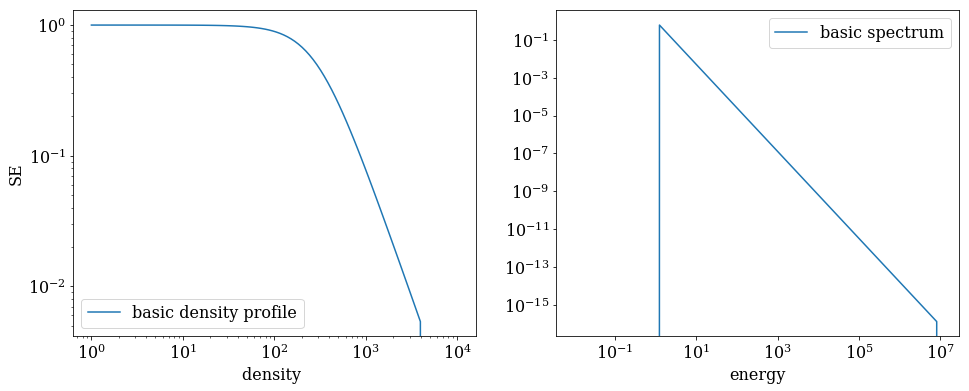

In [6]:
radius=np.logspace(0,4,100)*u.kpc
energy=np.logspace(-2,7,100)*u.GeV

# The simplest plots: density profile and spectrum
plt.figure(figsize=(15,6))
plt.subplot(121)

a ,b = get_normed_density_cre1_profile(clust, radius)
plt.loglog(a,b, label='basic density profile')

plt.xlabel('density ')
plt.ylabel('SE')
plt.legend()


plt.subplot(122)
c, d = get_normed_spectrum_cre1(clust,energy)
plt.loglog(c,d,label = 'basic spectrum')
plt.xlabel('energy')
plt.legend()

In [12]:

A = 1/u.GeV/u.cm**3


def cre1_2d(cl = clust, en= np.logspace(-2,7,100)*u.GeV, rd =np.logspace(0,4,100)*u.kpc):
    
    #norm
    #r = norm_electrons(clust)
    #norm_electrons(cl)
    #spatial
    rad, fd = get_normed_density_cre1_profile(cl, rd)
    fd2 = model_tools.replicate_array(fd.to_value('adu'), len(en), T = False )
    #energy
    eng, fe = get_normed_spectrum_cre1(cl, en)
    fe2 = model_tools.replicate_array(fe.to_value('adu'), len(rd), T = True )
    
    spectrum= A*fd2*fe2
     
    return spectrum.to('GeV-1 cm-3')



/home/astrogamma/.local/anaconda3/envs/cta/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


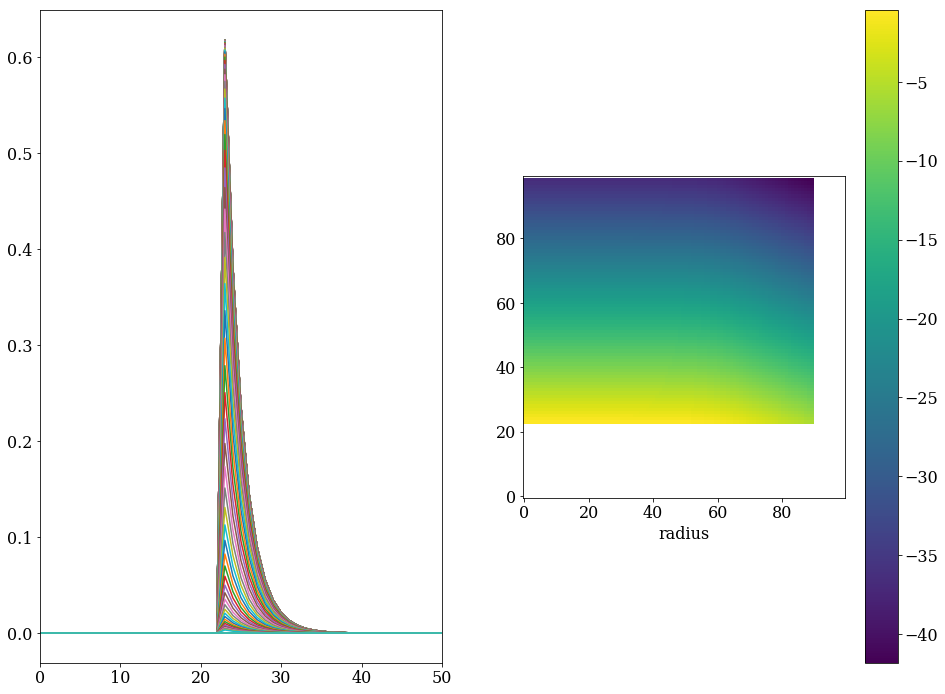

In [13]:

dndedv_try = cre1_2d( )

plt.figure(figsize = (15,12))
plt.subplot(122)
plt.imshow(np.log(dndedv_try.value), origin = 'lower')
plt.xlabel("radius")
plt.colorbar()

plt.subplot(121)
plt.plot(dndedv_try)
plt.xlim(0,50)
plt.show()

# Synchrotron

The failed attempts to rewrite the Cluster Emission Synchrotron function

## Rewrite the class function. Omit the Je function
Problem: Ee!!!
- if I leave NptEePd the array length is 1029 and I cannot use it for later calculations


In [26]:
#rate sync
from scipy.special import cbrt


def Gtilde( x):
  
        cb = cbrt(x) # x**1/3
        gt1 = 1.808 * cb / np.sqrt(1 + 3.4 * cb ** 2.0)
        gt2 = 1 + 2.210 * cb ** 2.0 + 0.347 * cb ** 4.0
        gt3 = 1 + 1.353 * cb ** 2.0 + 0.217 * cb ** 4.0
        
        return gt1 * (gt2 / gt3) * np.exp(-x)
    


def synchrotron( Ephoton_input, radius, B=1.0*u.uG):
        
        
        Eemin=(const.m_e*const.c**2).to('GeV'),
        Eemax= clust.Epmax
        NptEePd=clust.Npt_per_decade_integ
        #Electron energy
        Eemax = Eemaxo.to_value('GeV')
        Eeo = np.logspace(np.log10(Eemin), np.log10(Eemax), int(NptEePd*(np.log10(Eemax/Eemin))))
## 100)

        # Check input photons
        Ephoton = Ephoton_input.to('eV')
        if type(Ephoton) == float: Ephoton = np.array([Ephoton])
#Eemin = clust.Epmin 
#Eemax = clust.Epmax
      
        gamma = (Ee/(const.m_e*const.c**2).to_value('GeV')) # 1D
        ampli = np.sqrt(3)/(8*np.pi**2)*(const.e.value*const.e.unit)**3/(const.eps0*const.m_e*const.c*const.hbar)

        #---------- Case of integrated quantities, no radius
        # Get the electron distribution
        Je = cre1_2d( clust, Ee*u.GeV, radius).to_value('GeV-1 cm-3').T*u.GeV**-1
        #Je = Je*u.GeV**-1

        # Get the normalization function (1D: Ephot)
        func = ampli * B / Ephoton
        
        # Get the critical energy and energy ratio
        Ec = (3.0/2)*gamma**2*const.e.value*const.e.unit*B*const.hbar / (const.m_e) # 1D: Eelec
        EphotEc = Ephoton.to_value('GeV') / np.vstack(Ec.to_value('GeV')) # 2D: photon energy, electron energy

        # Compute integrand
        dNphot_dEdt = func * Gtilde(EphotEc)
        
        # Integrate over electron energy
        dNphot_dEdt = model_tools.trapz_loglog(np.vstack(Je.value)*Je.unit * dNphot_dEdt, Eeo*u.GeV, axis=0)

        # Get the output
        output = dNphot_dEdt.to('GeV-1 s-1')

        return output 
    
    
    
    

def rate_syncR(energy = np.logspace(-9,-2,100)*u.eV, radius = np.logspace(0,4,100)*u.kpc ):
    
   #Get Magnetic field
    radius, B = clust.get_magfield_profile(radius)
        
    rate = synchrotron( energy, radius, B).T
    
    return rate.to('GeV-1 cm-3 s-1')




In [29]:
#For comparison, here use the class
from ClusterModel.ClusterTools import cluster_electron_emission as emi


def rate_sync(energy = np.logspace(-9,-2,100)*u.eV, radius = np.logspace(0,4,100)*u.kpc ):
    
    #Get Magnetic field
    radius, B = clust.get_magfield_profile(radius)
    
    #Define Je: 
    def Je2( rad, eng): return cre1_2d(clust, eng*u.GeV, rad*u.kpc).to_value('GeV-1 cm-3').T
    
    #Use the class
    model =  emi.ClusterElectronEmission (Je = Je2,Eemin=(const.m_e*const.c**2).to('GeV'), NptEePd=clust._Npt_per_decade_integ)
    rate = model.synchrotron( energy, radius_input = radius, B=B).T
    
    return rate.to('GeV-1 cm-3 s-1')

## Compare

In [30]:

noclass = rate_syncR()
yesclass = rate_sync()
default = clust.get_rate_synchrotron()


Getting the maximal proton energy


ValueError: operands could not be broadcast together with shapes (1029,) (100,) 

In [40]:
int(NptEePd*(np.log10(Eemaxo/Eemino)))

1029

# Do everything in the Cluster Emission class; No Radius
- B field is constant
- Photon energy input has to have same length as electron energy, otherwise doesnt work

In [43]:
len(Je)

100

In [53]:
#rate sync
from scipy.special import cbrt


def Gtilde( x):
        """
        Useful equation. Aharonian, Kelner, Prosekin 2010 Eq. D7
        Taken from Naima.
        
        Factor ~2 performance gain in using cbrt(x)**n vs x**(n/3.)
        Invoking crbt only once reduced time by ~40%
        """
        cb = cbrt(x) # x**1/3
        gt1 = 1.808 * cb / np.sqrt(1 + 3.4 * cb ** 2.0)
        gt2 = 1 + 2.210 * cb ** 2.0 + 0.347 * cb ** 4.0
        gt3 = 1 + 1.353 * cb ** 2.0 + 0.217 * cb ** 4.0
        
        return gt1 * (gt2 / gt3) * np.exp(-x)
    
    
    

#radius = np.logspace(0,4,100)*u.kpc
    
#Constant B Field

B=1.0*u.uG

#rate = synchrotron( energy, radius, B).T
    
    

    
 #   def synchrotron( Ephoton_input, radius, B=1.0*u.uG):
        
NptEePd = clust._Npt_per_decade_integ
        #Electron energy
Eemino = (const.m_e *const.c**2).to_value('GeV')
Eemaxo = clust.Epmax
Eemaxo = Eemaxo.to_value('GeV')
Eeo = np.logspace(np.log10(Eemino), np.log10(Eemaxo), int(NptEePd*(np.log10(Eemaxo/Eemino))))

        # Check input photons
    
    
energy = np.logspace(-9,-2,len(Eeo))*u.eV

Ephoton = energy.to('eV')
if type(Ephoton) == float: Ephoton = np.array([Ephoton])
#Eemin = clust.Epmin 
#Eemax = clust.Epmax
      
    
    
gamma = (Eeo/(const.m_e*const.c**2).to_value('GeV')) # 1D
ampli = np.sqrt(3)/(8*np.pi**2)*(const.e.value*const.e.unit)**3/(const.eps0*const.m_e*const.c*const.hbar)

        #---------- Case of integrated quantities, no radius
        # Get the electron distribution
Je = cre1_2d( clust, Eeo*u.GeV, np.logspace(0,4,len(Eeo))*u.kpc).to_value('GeV-1 cm-3').T*u.GeV**-1
        #Je = Je*u.GeV**-1

        # Get the normalization function (1D: Ephot)
func = ampli * B / Ephoton
        
        # Get the critical energy and energy ratio
Ec = (3.0/2)*gamma**2*const.e.value*const.e.unit*B*const.hbar / (const.m_e) # 1D: Eelec
EphotEc = Ephoton.to_value('GeV') / np.vstack(Ec.to_value('GeV')) # 2D: photon energy, electron energy

        # Compute integrand
dNphot_dEdt = func * Gtilde(EphotEc)
        
        # Integrate over electron energy
dNphot_dEdt = model_tools.trapz_loglog(np.vstack(Je.value)*Je.unit * dNphot_dEdt, Eeo*u.GeV, axis=0)

        # Get the output
output = dNphot_dEdt.to('GeV-1 s-1')

output
    

Getting the maximal proton energy


<Quantity [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00

## Electron energy

In [50]:
NptEePd = clust._Npt_per_decade_integ
        #Electron energy
        
        #Electron energy
Eemino = (const.m_e *const.c**2).to_value('GeV')
Eemaxo = clust.Epmax
Eemaxo = Eemaxo.to_value('GeV')
Eeo = np.logspace(np.log10(Eemino), np.log10(Eemaxo),    int(NptEePd*(np.log10(Eemaxo/Eemino))))
A = 1/u.GeV/u.cm**3
radius = np.logspace(0,4,100)*u.kpc 
lolz = cre1_2d(  clust , Eeo*u.GeV, radius).to_value('GeV-1 cm-3').T*u.GeV**-1
lolz

Getting the maximal proton energy


<Quantity [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            1.13292437e-16, 9.48632235e-17, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            1.13292162e-16, 9.48629929e-17, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            1.13291830e-16, 9.48627150e-17, 0.00000000e+00],
           ...,
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            0.00000000e+00, 0.00000000e+00, 0.00000000e+00]] 1 / GeV>

## Why are my energies so low!?!???

In [37]:
radius = np.logspace(0,4,100)*u.kpc 
radius, B = clust.get_magfield_profile(radius)
rate = synchrotron( energy, radius, B).T

Getting the maximal proton energy


ValueError: operands could not be broadcast together with shapes (1029,) (100,) 

In [39]:

Rmin = clust._Rmin
Rmax = clust._R500     
    #sample radius
rad = model_tools.sampling_array(Rmin, Rmax, NptPd = clust._Npt_per_decade_integ, unit = True)


A = (1/u.GeV/u.cm**3)
cl = clust
freq = np.logspace(-3,2,100)*u.GHz

energy = (const.h*freq).to('eV')
    



dNdEdVdt = rate_sync(energy, radius)